In [1]:
import os
import pandas as pd
import numpy as np
import glob

desired_width = 320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns', 10)

In [2]:
##############################################################################
# Load and clean Rating data                                                 #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\Rating.csv'
df_ratings_raw = pd.read_csv(path)

# drop RatingSPOutlook,RatingSPOutlook columns
df_ratings_no_xtra_col = df_ratings_raw.drop(columns=['RatingSPOutlook', 'RatingSPOutlook.1'])

# drop NA from RatingSP column
df_ratings_clean = df_ratings_no_xtra_col.dropna(subset=['RatingSP'])

# calculate mean per security by removing KeyDate
df_ratings_clean = df_ratings_clean.drop(columns=['KeyDate'])
df_ratings_with_mean = df_ratings_clean.groupby(['SecurityID']).mean()
df_ratings_with_mean.reset_index()

,SecurityID,RatingSP
0,64,10.000000
1,72,13.000000
2,78,14.652361
3,82,15.000000
4,83,14.652361
...,...,...
17918,72406,14.000000
17919,72407,14.000000
17920,72504,17.000000
17921,72675,8.000000


In [3]:
##############################################################################
# Load and clean Spreads data                                                #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\raw_data_files'
all_files = glob.glob(os.path.join(path, "*.csv"))  # use os.path.join to make concat OS independent

df_from_each_file = (pd.read_csv(f) for f in all_files)
df_merged = pd.concat(df_from_each_file, ignore_index=True, sort=False)

In [4]:
# drop na from spreads data
df_merged = df_merged.dropna(how='any')
# convert dates to Date type
df_merged['KeyDate'] = pd.to_datetime(df_merged['KeyDate'], errors='coerce')

# Extract the low liers
dates_low_liers = df_merged["KeyDate"].value_counts()
dates_low_liers = dates_low_liers[dates_low_liers < 500]

# clean the dataset by removing the low liers and NaNs
df_merged_clean = df_merged[~df_merged['KeyDate'].isin(dates_low_liers.index)]

# drop KeyDate column
df_data_values = df_merged_clean.drop(columns=['KeyDate'])

# group by security and average all other columns
df_data_values_with_mean = df_data_values.groupby(['SecurityID']).mean()
df_data_values_with_mean.reset_index()

,SecurityID,Price,YieldWorst,ModifiedDuration_Plain,AmtOutstanding,GSpread,OAS_Spread,ZSpread,AswUsd
0,64,100.758965,4.644316,5.757035,1.697266e+09,291.711174,222.352441,288.657755,283.687773
1,72,107.373280,3.940311,3.330841,1.000000e+09,227.002913,223.490338,223.329880,229.235868
2,78,103.207920,3.477836,1.945063,8.000000e+08,180.855440,176.403676,171.764407,169.003940
3,82,115.672100,4.473227,14.990642,2.000000e+09,217.044085,215.316896,245.880015,265.958284
4,83,106.167899,3.416090,1.207811,1.000000e+09,171.659279,164.354293,154.729040,157.830712
...,...,...,...,...,...,...,...,...,...
19808,72944,95.239076,4.044686,4.417710,7.500000e+08,366.768519,361.804353,356.978706,342.727059
19809,72948,90.060159,11.504231,2.250852,4.000000e+08,1124.316903,1120.898118,1109.677059,1022.199941
19810,72949,88.003900,6.550267,55.330667,5.000000e+08,500.722641,566.272333,595.348333,614.242667
19811,72950,90.583533,7.934610,53.381167,3.000000e+08,639.156975,697.474333,733.633667,621.808000


In [5]:
##############################################################################
# Load and clean Securities meta data                                        #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\SecurityData.csv'  # use your path
df_securities = pd.read_csv(path)

# filter out CountryDomicile=US
df_securities_US = df_securities.loc[df_securities['CountryDomicile'] == 'US']

In [6]:
##############################################################################
# Merge all the datasets into one DataFrame / File                           #
##############################################################################

# left join RatingSP from df_rating on df_securities and replace NA with zero
df_securities_US_w_avg_rating = df_securities_US.merge(df_ratings_with_mean, on=['SecurityID'], how='left')
df_securities_US_w_avg_rating['RatingSP'] = df_securities_US_w_avg_rating['RatingSP'].fillna(0)


# left join all columns by SecurityID from df_avg_data_values into df_securities_US_w_avg_rating
df_securities_US_w_data = df_securities_US_w_avg_rating.merge(df_data_values_with_mean, on=['SecurityID'], how='left')

# drop rows from df_securities_US_w_data without average spreads
df_securities_US_w_data_clean = df_securities_US_w_data.dropna(subset=['Price', 'YieldWorst', 'ModifiedDuration_Plain',
                                                                       'AmtOutstanding', 'GSpread', 'OAS_Spread', 'ZSpread', 'AswUsd'])

# TEMP - output df_securities to US_Securities_with_AVG_Rating_AVG_Spreads.csv
df_securities_US_w_data_clean.to_csv(r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\US_Securities_with_AVG_Rating_AVG_Spreads.csv')


In [7]:
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
from scipy.spatial.distance import cdist

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from time import time

%matplotlib inline

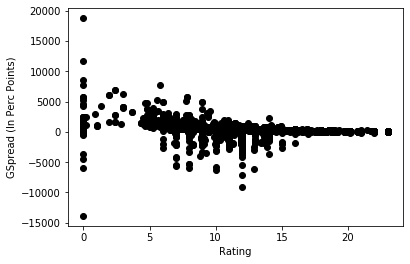

In [8]:
X = df_securities_US_w_data_clean[["RatingSP","GSpread"]]
#Visualise data points
plt.scatter(X["RatingSP"],X["GSpread"],c='black')
plt.xlabel('Rating')
plt.ylabel('GSpread (In Perc Points)')
plt.show()

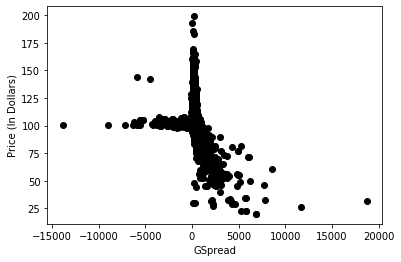

In [9]:
X = df_securities_US_w_data_clean[["GSpread","Price"]]
#Visualise data points
plt.scatter(X["GSpread"],X["Price"],c='black')
plt.xlabel('GSpread')
plt.ylabel('Price (In Dollars)')
plt.show()

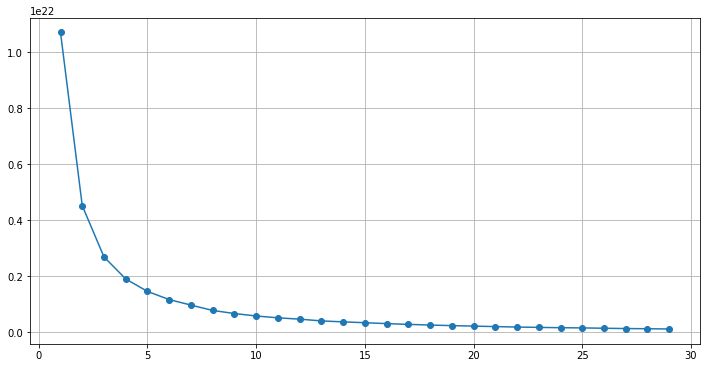

In [122]:
K = range(1,30)
df = df_securities_US_w_data_clean[['Price', 'GSpread', 'RatingSP', 'YieldWorst', 'ModifiedDuration_Plain',
                                    'AmtOutstanding', 'OAS_Spread', 'ZSpread', 'AswUsd', 
                                    'Coupon', 'AmountIssued']]


fits = [KMeans(n_clusters=k, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df) for k in K]
centroids = [fit.cluster_centers_ for fit in fits]
inertias = [fit.inertia_ for fit in fits]


# Elbow - Works
clusters_df = pd.DataFrame( { "num_clusters":K, "cluster_errors": inertias } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.grid()
plt.show()


In [123]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df)
centroids_gspread = kmeans.cluster_centers_
inertias_gspread = kmeans.inertia_
print(centroids_gspread)
print(inertias_gspread)


[[1.05194650e+02 2.41348371e+02 1.41557072e+01 4.17386051e+00 7.28601629e+00 3.85495067e+08 2.23211181e+02 2.44716222e+02 2.33764633e+02 4.89655246e+00 4.04535750e+08]
 [1.03238365e+02 1.98541004e+02 1.50321916e+01 3.63821696e+00 6.93286920e+00 8.84548097e+08 1.81190386e+02 1.99677165e+02 2.02113508e+02 4.36773105e+00 9.15166964e+08]
 [1.04979511e+02 1.60847427e+02 1.52678170e+01 3.30216945e+00 8.60267747e+00 1.67564899e+09 1.42963563e+02 1.62659137e+02 1.67017278e+02 4.47166833e+00 1.77648002e+09]
 [1.08179759e+02 1.68228463e+02 1.61612903e+01 3.43979508e+00 1.08163156e+01 4.78204269e+09 1.65363082e+02 1.78842236e+02 1.85171548e+02 4.22380645e+00 7.04327042e+09]
 [1.05583991e+02 1.52153060e+02 1.62700995e+01 3.19907690e+00 7.77342271e+00 2.98646463e+09 1.44142994e+02 1.55373484e+02 1.66845021e+02 4.04793003e+00 3.09376883e+09]]
1.4647739179902215e+21


In [124]:
preds = kmeans.fit_predict(df)
print(len(preds))

# df_securities_US_w_data_clean
df_test = df_securities_US_w_data_clean.copy()

df_test['ClusterTag'] = pd.Series(preds, index=df_test.index)
df_test.to_csv(r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\df_test.csv')

12219


[[  178.94032187   105.97915289]
 [ 1144.82568711    85.24324349]
 [-1958.72961106   101.94507181]
 [-6139.31974919   106.75389907]
 [ 5798.84214399    46.45054401]]
847965068.3043481


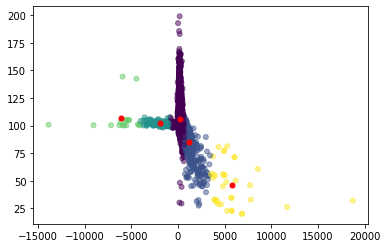

In [130]:
# Visualization only
df_2 = df[['GSpread', 'Price']]

kmeans2 = KMeans(n_clusters=5, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df_2)
centroids_kmeans2 = kmeans2.cluster_centers_
inertias_kmeans2 = kmeans2.inertia_
print(centroids_kmeans2)
print(inertias_kmeans2)

plt.scatter(df_2['GSpread'], df_2['Price'], c= kmeans2.labels_.astype(float), s=25, alpha=0.5)
plt.scatter(centroids_kmeans2[:, 0], centroids_kmeans2[:, 1], c='red', s=25)
plt.show()

[[ 1.78940322e+02  1.50258051e+01]
 [ 1.14482569e+03  8.14491422e+00]
 [-1.95872961e+03  1.07562685e+01]
 [-6.13931975e+03  7.81820487e+00]
 [ 5.79884214e+03  3.65605211e+00]]
846798119.6842337


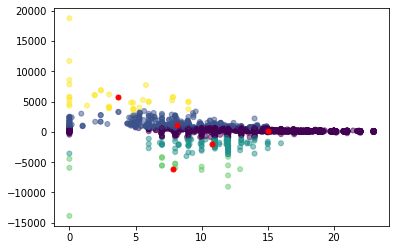

In [136]:
# Visualization only
df_3 = df[['GSpread', 'RatingSP']]

kmeans3 = KMeans(n_clusters=5, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df_3)
centroids_kmeans3 = kmeans3.cluster_centers_
inertias_kmeans3 = kmeans3.inertia_
print(centroids_kmeans3)
print(inertias_kmeans3)

plt.scatter(df_3['RatingSP'], df_3['GSpread'], c= kmeans3.labels_.astype(float), s=25, alpha=0.5)
plt.scatter(centroids_kmeans3[:, 1], centroids_kmeans3[:, 0], c='red', s=25)
plt.show()

In [137]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 


K = range(1,30)

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df) 
    kmeanModel.fit(df)     
      
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / df.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

    

In [140]:
# Tabulate the different values of Distortion
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 603610887.7233683
2 : 405230668.9045199
3 : 301335852.1408393
4 : 246985231.1020799
5 : 234049861.9781005
6 : 204304707.32714078
7 : 176761895.16268006
8 : 159501181.27886653
9 : 147818002.89634016
10 : 125539344.4847381
11 : 122093891.92075518
12 : 122172802.31190497
13 : 118391956.09188662
14 : 104397112.63815178
15 : 100934939.38484876
16 : 96282526.79650061
17 : 87977085.66457917
18 : 85114555.89721273
19 : 84377435.58273093
20 : 75847254.73131241
21 : 74994684.52904712
22 : 73741711.02596115
23 : 63973476.191504285
24 : 59992557.7066531
25 : 63806975.43548785
26 : 60906009.43330599
27 : 55418819.08081497
28 : 54667508.9353872
29 : 54242207.879752144


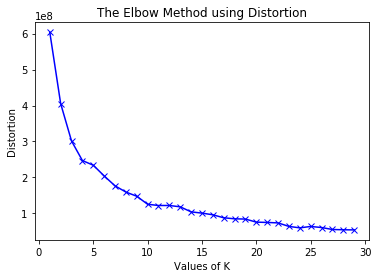

In [141]:
# Visualize the different values of Distortion
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [142]:
# Tabulate the different values of Inertia
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

1 : 1.0706813318388586e+22
2 : 4.5250972655043006e+21
3 : 2.695895139228578e+21
4 : 1.910698041143052e+21
5 : 1.4647739179902215e+21
6 : 1.1740002616444394e+21
7 : 9.77370722255421e+20
8 : 7.861873355599487e+20
9 : 6.762139605637216e+20
10 : 5.8871332165821366e+20
11 : 5.226256716696497e+20
12 : 4.7539649945212754e+20
13 : 4.122752201282133e+20
14 : 3.7893019270821564e+20
15 : 3.479862565462584e+20
16 : 3.162243381097303e+20
17 : 2.8929307477606823e+20
18 : 2.6471632732903352e+20
19 : 2.4503591033439178e+20
20 : 2.2692812467476352e+20
21 : 2.1050980563408136e+20
22 : 1.9333396086106027e+20
23 : 1.8154110471759633e+20
24 : 1.6993422422314035e+20
25 : 1.633630195894164e+20
26 : 1.5098886834021682e+20
27 : 1.4055980340405767e+20
28 : 1.3332373252147179e+20
29 : 1.2496984442282197e+20


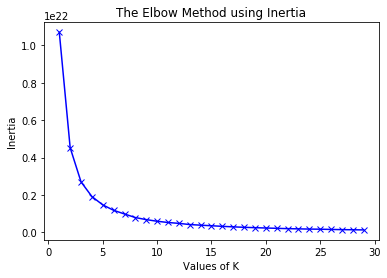

In [143]:
# Visualize the different values of Inertia
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 